In [1]:
import numpy as np
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('wordnet')
import re
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/habkaffee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/habkaffee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# dataset = pd.read_csv('data/DATASET.csv')
# dataset

# Preprocessing

In [3]:
exclude_symbols = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                            '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                            '\x7f', '\xad', '¤', '\xa0', '\u200b', '–']) + string.punctuation
regex_symb = re.compile('[%s]' % re.escape(exclude_symbols))

In [4]:
stop_words = stopwords.words('english')
pattern = r'\b(?:' + '|'.join(stop_words) + r')\b'
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [5]:
tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

In [6]:
# def lemmatize_sentence(sentence):
#     if isinstance(sentence, str):
#       sentence = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(sentence)]
#     return sentence

In [7]:
dataset = pd.read_csv('data/DATASET.csv')

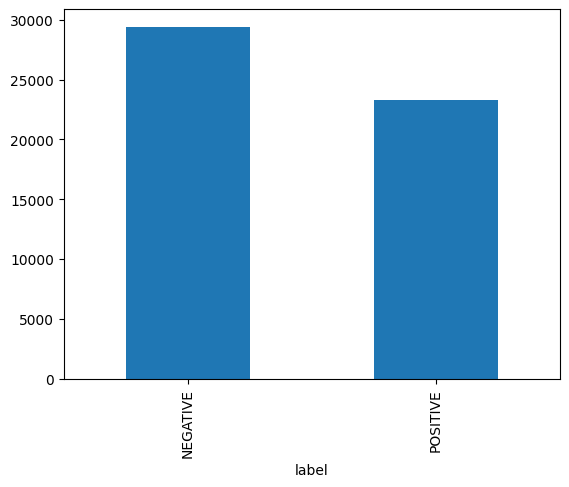

In [8]:
plt.figure()
dataset['label'].value_counts().plot.bar()
plt.show()

In [9]:
dataset['Review'] = dataset['Review'].str.lower()
dataset = dataset.loc[dataset['Review'].apply(lambda x: isinstance(x, str) and x.isascii())]
dataset['label'] = dataset['label'].str.replace('POSITIVE', '1').replace('NEGATIVE', '0')
dataset['Review'] = dataset['Review'].str.replace(pattern, '', regex=True)
dataset['Review'] = dataset['Review'].str.replace(f'[{string.punctuation}]+', ' ', regex=True)
dataset['Review'] = dataset['Review'].str.replace(r'\s+', ' ', regex=True)
dataset['Review'] = dataset['Review'].str.replace(f'[0-9]+', '', regex=True)

dataset['Review'] = dataset['Review'].apply(lambda sentence : tokenizer.tokenize(sentence))
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='n') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='v') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='a') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='r') for word in sentence])
# dataset['Review'] = dataset['Review'].apply(lambda sentence : ' '.join(sentence))
dataset

,Review,label
0,"[great, music, service, audio, high, quality, ...",1
1,"[please, ignore, previous, negative, rat, app,...",1
2,"[pop, get, best, spotify, experience, android,...",0
3,"[really, buggy, terrible, use, recently]",0
4,"[dear, spotify, get, song, put, playlist, shuf...",0
...,...,...
52697,"[yes, best]",1
52698,"[spotify, heart, feb, heart, music, lyric, lan...",1
52699,"[try, open, app, wont, open, restart, phone, i...",1
52700,[good],1


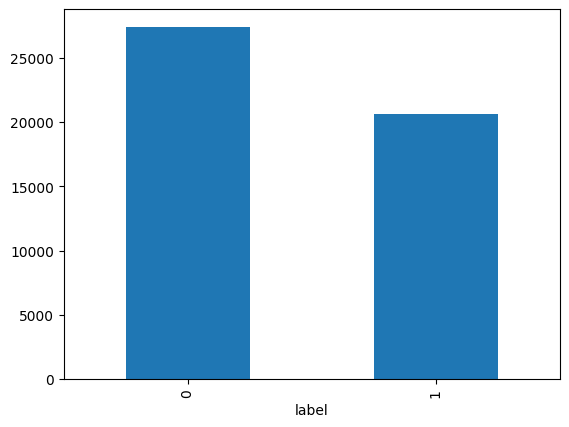

In [10]:
plt.figure()
dataset['label'].value_counts().plot.bar()
plt.show()

In [24]:
negative_df = dataset[dataset['label'] == '0']['Review'].apply(lambda x : ' '.join(x))
positive_df = dataset[dataset['label'] == '1']['Review'].apply(lambda x : ' '.join(x))

In [28]:
neg_res = negative_df.str.split(expand=True).stack().value_counts()
neg_res

song          17863
app           17285
play          13951
music          9206
spotify        8236
              ...  
wats              1
doooing           1
ingredient        1
margarita         1
unabled           1
Name: count, Length: 11726, dtype: int64

In [29]:
pos_res = positive_df.str.split(expand=True).stack().value_counts()
pos_res

music         10125
app            9199
song           6018
spotify        5287
love           5097
              ...  
connexion         1
anxious           1
horrendous        1
manualy           1
iykyk             1
Name: count, Length: 8406, dtype: int64

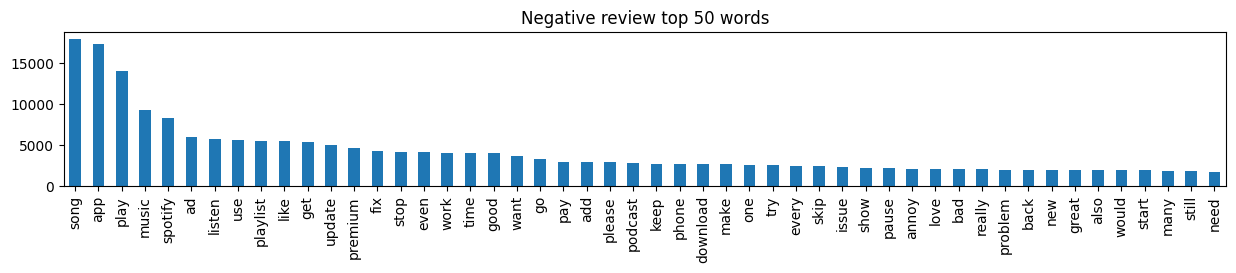

In [39]:
plt.figure(figsize=(15, 2))
neg_res[:50].plot.bar()
plt.title('Negative review top 50 words')
plt.show()

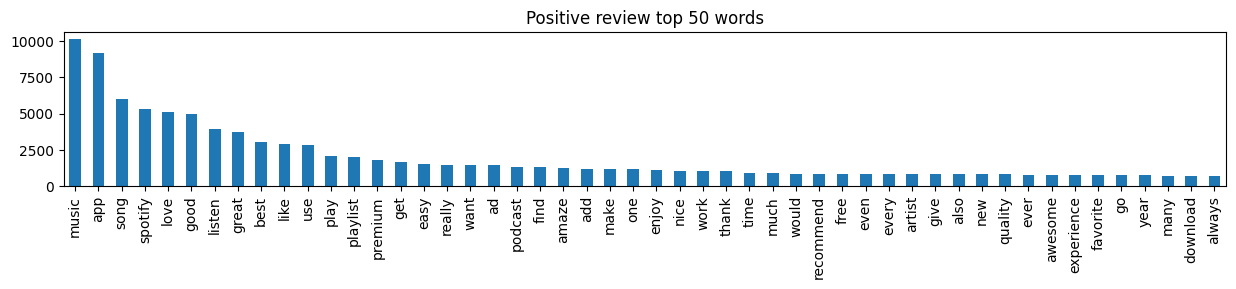

In [40]:
plt.figure(figsize=(15, 2))
pos_res[:50].plot.bar()
plt.title('Positive review top 50 words')
plt.show()

In [41]:
X, Y = dataset['Review'], dataset['label']

In [42]:
X.head()

0    [great, music, service, audio, high, quality, ...
1    [please, ignore, previous, negative, rat, app,...
2    [pop, get, best, spotify, experience, android,...
3             [really, buggy, terrible, use, recently]
4    [dear, spotify, get, song, put, playlist, shuf...
Name: Review, dtype: object

In [43]:
Y.head()

0    1
1    1
2    0
3    0
4    0
Name: label, dtype: object

In [44]:
all_words = set()
for data in X:
    all_words.update(data)
pd.DataFrame(all_words).T

,0,1,2,3,4,5,6,7,8,9,...,15392,15393,15394,15395,15396,15397,15398,15399,15400,15401
0,horsepower,cor,undesirable,complimentary,naaa,easypaisa,gife,importance,jerk,prize,...,execution,musicentertainment,uselessness,impassable,pausan,wabt,sindhi,batman,noodle,sticky


In [45]:
len(all_words)

15402

In [46]:
vectorizer = Word2Vec(X, vector_size=100, workers=4, min_count=3)
seed = 42

In [47]:
vectorizer.wv['app']

array([-0.13068163, -0.15744853,  0.3068293 ,  0.8401219 , -1.0191028 ,
       -0.29953632, -0.44151422,  0.50364906, -0.66136366, -0.01739978,
        0.30604503,  0.5580704 , -0.6097056 ,  0.7410617 , -0.04736211,
       -0.2282349 , -0.39821994, -0.01798098, -0.06747671,  0.7110215 ,
        0.595442  , -0.03178932,  0.39236137, -0.03309065,  1.27652   ,
        0.24887502,  1.0628345 ,  0.16255039, -0.3316421 ,  1.0591385 ,
       -0.25832653, -0.38884467,  0.8533912 , -0.49473017,  0.3510067 ,
        0.4516905 ,  0.34495455, -0.16691251,  0.743651  , -0.89890987,
       -0.55687445,  0.8044548 ,  0.18774505,  0.02869305,  0.468393  ,
       -0.321181  ,  0.07545455,  0.79491776,  1.3727415 , -0.4316848 ,
        0.39078742,  0.53675383,  0.32134706, -0.8540782 ,  2.1821036 ,
       -0.64138216, -0.1412169 , -0.37595445,  0.25054118, -0.2006729 ,
       -0.3310095 ,  0.4063986 , -0.34725967, -0.9861636 , -0.72206813,
        0.34082505,  0.44982532,  0.9402808 , -0.6398609 , -0.94

In [48]:
def sentence_to_vector(sentence, model, vector_size):
    # Filter out words that are not in the model vocabulary
    words = [word for word in sentence if word in model.wv]
    if not words:
        return np.zeros(vector_size)  # Return a zero vector if no words in the model
    return np.mean([model.wv[word] for word in words], axis=0)

X_vectors = np.array([sentence_to_vector(sentence, vectorizer, 100) for sentence in X])

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X_vectors, Y.astype(np.int8), test_size=0.25, random_state=seed)

# ML algs

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [51]:
def get_gridsearch_for_model(model, parameters : dict) -> GridSearchCV:
    model_grid = GridSearchCV(
        estimator=model,
        param_grid=parameters,
        scoring=['f1_micro', 'accuracy', 'recall_macro'],
        refit='f1_micro',
        cv=5,
        verbose=2,
        error_score=0,
        n_jobs=8
    )
    return model_grid

def print_grid_search_info(model):
    print(f'Best estimator -> {model.best_estimator_}\n\
Best Score -> {model.best_score_}\n\
Best Parameters -> {model.best_params_}\n\
Best index -> {model.best_index_}')


def print_metrics(y_test, y_pred):
    print(f'accuracy_score = {accuracy_score(y_test, y_pred)}\nf1_micro = {f1_score(y_test, y_pred, average="micro")}\nrecall_score = {recall_score(y_test, y_pred, average="macro")}\nprecision_score = {precision_score(y_test, y_pred, average="macro")}')


def display_conf_matrix(y_true, y_pred, Y):
    conf_matrix = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=Y.unique())
    cm_display.plot()
    plt.show()

In [52]:
parameters_logreg = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 0.5, 1.0, 10.0],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 500, 1000]
}

grid_log = get_gridsearch_for_model(LogisticRegression(), parameters_logreg)

grid_log.fit(X_train, Y_train)
print_grid_search_info(grid_log)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END .....C=0.01, max_iter=100, penalty=l2,

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=0.5, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.6s
[CV] END ......C=0.5, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.3s
[CV] END ......C=0.5, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.5s
[CV] END ..C=0.5, max_iter=100, penalty=l2, solver=liblinear; total time=   3.7s
[CV] END ..C=0.5, max_iter=100, penalty=l2, solver=liblinear; total time=   3.9s
[CV] END ..C=0.5, max_iter=100, penalty=l2, solver=liblinear; total time=   4.0s
[CV] END ......C=0.5, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=0.5, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=0.5, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=0.5, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=0.5, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..C=0.5, max_iter=100, penalty=l2, solver=liblinear; total time=   3.8s
[CV] END ..C=0.5, max_iter=1

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.4s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.5s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   4.1s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   4.0s
[CV] END .C=0.5, max_iter=1000, penalty=l1, solver=liblinear; total time=  30.5s
[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.4s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   5.1s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   5.4s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   5.5s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   5.2s
[CV] END ..C=1.0, max_iter=1

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.2s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.3s
[CV] END .C=1.0, max_iter=1000, penalty=l1, solver=liblinear; total time=  41.7s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.4s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.3s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=  11.6s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=  13.5s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=  14.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=   9.4s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=   8.5s
[CV] END .C=10.0, max_iter=100, penalty=l1, solver=liblinear; total time= 1.8min
[CV] END .C=10.0, max_iter=1

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
75 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best estimator -> LogisticRegression(C=10.0, solver='liblinear')
Best Score -> 0.860887656033287
Best Parameters -> {'C': 10.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best index -> 51


In [53]:
Y_pred_logreg = grid_log.predict(X_test)
print_metrics(Y_test, Y_pred_logreg)
# save_model('./models/log_reg_trash.pkl', grid_log)

accuracy_score = 0.8587001747524341
f1_micro = 0.8587001747524341
recall_score = 0.8520170196281356
precision_score = 0.8583366650979308


In [54]:
parameters_linSVC = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.linspace(0.001, 0.1, 7),
    'max_iter': [1000, 3000, 5000],
    'dual':[True]
}

grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l2; 

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.1s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.1s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   1.1s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.1s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   1.1s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.034

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   1.1s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.5s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.2s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.6s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=5000, penalty=l2; tota

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.8s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.9s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   1.8s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.5s
[CV] END C=0.0505,

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.4s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.4s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   2.7s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.5s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   2.8s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   2.6s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   2.7s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   2.9s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   2.8s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.5s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.6s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.6s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.6s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.7s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=  

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.5s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.5s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.5s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.5s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.4s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   4.2s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   4.5s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   4.2s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   4.5s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.7s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   4.4s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   4.2s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.7s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   4.3s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.6s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   1.2s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.6s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   1.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.7s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   1.2s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   1.2s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   1.4s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; tot

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.4s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   2.6s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.5s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.4s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.4s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.5s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   6.5s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   6.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.5s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   6.2s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.5s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   6.6s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   6.4s
[CV] END C=0.0835, dual=True, lo

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.6s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.6s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.6s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.8s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.8s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   4.4s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   4.6s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   4.6s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   4.6s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; tota

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
210 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best estimator -> LinearSVC(C=0.1, dual=True)
Best Score -> 0.859889042995839
Best Parameters -> {'C': 0.1, 'dual': True, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2'}
Best index -> 79


In [55]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)

accuracy_score = 0.8579512357493551
f1_micro = 0.8579512357493551
recall_score = 0.8504392472228938
precision_score = 0.8583893691685066


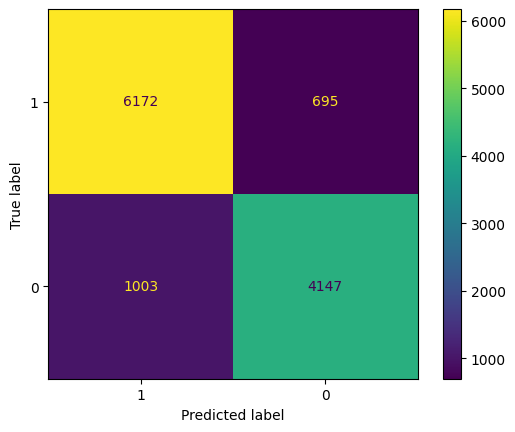

In [56]:
display_conf_matrix(Y_test, Y_pred_logreg, Y)

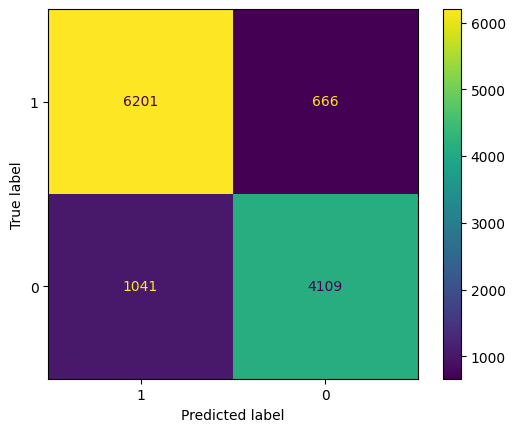

In [57]:
display_conf_matrix(Y_test, Y_pred_linSVC, Y)

И linear SVC, и logistic regression отрабатывают примерно одинаково и допускают много ошибок при классификации. Это связано с тем, что часто в негативных и позитивных отзывах используются схожие конструкции и слова

# NN Models

## Fully connected

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim

class FC_binary(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.activation(out)
        return out

In [59]:
vector_size = 100
hidden_dim = 64
output_dim = 1
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Used device -> {device}')

fc_bin = FC_binary(vector_size, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(fc_bin.parameters(), lr=learning_rate)

Used device -> cuda


In [60]:
X_train_nn = torch.tensor(X_train, dtype=torch.float32)
X_test_nn = torch.tensor(X_test, dtype=torch.float32)
Y_train_nn = torch.tensor(Y_train.to_numpy(), dtype=torch.float32)
Y_test_nn = torch.tensor(Y_test.to_numpy(), dtype=torch.float32)

In [61]:
fc_bin.to(device=device)

FC_binary(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [62]:
num_epochs = 100
batch_size = 32
train_data = torch.utils.data.TensorDataset(X_train_nn, Y_train_nn)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [63]:
for epoch in range(num_epochs):
    fc_bin.train()
    total_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device=device)
        Y_batch = Y_batch.to(device=device)
        
        outputs = fc_bin(X_batch).squeeze(1)
        loss = criterion(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')


Epoch 1/100, Loss: 0.36027650382392895
Epoch 2/100, Loss: 0.33237632765982567
Epoch 3/100, Loss: 0.3246369982582865
Epoch 4/100, Loss: 0.31984774211046435
Epoch 5/100, Loss: 0.31595341911491504
Epoch 6/100, Loss: 0.31303116886776533
Epoch 7/100, Loss: 0.3104856108656581
Epoch 8/100, Loss: 0.30855044339119914
Epoch 9/100, Loss: 0.30724823922447747
Epoch 10/100, Loss: 0.3051706393709623
Epoch 11/100, Loss: 0.30338438039690174
Epoch 12/100, Loss: 0.3021234356415621
Epoch 13/100, Loss: 0.3013994264240379
Epoch 14/100, Loss: 0.29950992461581516
Epoch 15/100, Loss: 0.2983772571809332
Epoch 16/100, Loss: 0.2973545715212822
Epoch 17/100, Loss: 0.2963282409807487
Epoch 18/100, Loss: 0.29520607729770487
Epoch 19/100, Loss: 0.29424222930274185
Epoch 20/100, Loss: 0.2940121881842296
Epoch 21/100, Loss: 0.29330358416926255
Epoch 22/100, Loss: 0.2917853343600495
Epoch 23/100, Loss: 0.29114438220528027
Epoch 24/100, Loss: 0.2906495445501307
Epoch 25/100, Loss: 0.28933863951341177
Epoch 26/100, Loss: 

In [64]:
fc_bin.eval()
X_test_nn = X_test_nn.to(device=device)
Y_test_nn = Y_test_nn.to(device=device)
with torch.no_grad():
    outputs = fc_bin(X_test_nn).squeeze(1)
    predictions = (outputs > 0.5).float()
    accuracy = (predictions == Y_test_nn).float().mean()
    print(f'Test Accuracy: {accuracy:.8f}')
    
torch.save(fc_bin.state_dict(), f'./models/fc_test_{accuracy:.5f}.pth')

Test Accuracy: 0.86544067


## CNN Classifier

In [65]:
class CNNTextClassifier(nn.Module):
    def __init__(self, embedding_dim, num_filters, filter_sizes, output_dim, dropout=0.5):
        super().__init__()
        
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=fs) for fs in filter_sizes
        ])
        
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        
        conved = [torch.relu(conv(x)) for conv in self.convs]
        pooled = [torch.max(c, dim=2)[0] for c in conved] # Max pooling over dims
        
        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)
        
        output = self.fc(cat)
        
        return torch.sigmoid(output).squeeze(1)



In [66]:
vector_size = 100
num_filters = 100
filter_sizes = [3, 4, 5]  # Filter sizes for 3-grams, 4-grams, and 5-grams
output_dim = 1 
dropout = 0.5

In [67]:
CNN_bin = CNNTextClassifier(vector_size, num_filters, filter_sizes, output_dim, dropout)
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN_bin.parameters(), lr=learning_rate)

In [68]:
CNN_bin.to(device=device)

CNNTextClassifier(
  (convs): ModuleList(
    (0): Conv1d(1, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(1, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(1, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [69]:
num_epochs = 50
batch_size = 32
train_data = torch.utils.data.TensorDataset(X_train_nn, Y_train_nn)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    CNN_bin.train()
    total_loss = 0
    for X_batch, Y_batch in train_loader:
        # Forward pass
        
        X_batch = X_batch.to(device=device)
        Y_batch = Y_batch.to(device=device)
        outputs = CNN_bin(X_batch)
        loss = criterion(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}')

Epoch 1/50, Loss: 0.5638
Epoch 2/50, Loss: 0.5003
Epoch 3/50, Loss: 0.4906
Epoch 4/50, Loss: 0.4797
Epoch 5/50, Loss: 0.4764
Epoch 6/50, Loss: 0.4743
Epoch 7/50, Loss: 0.4683
Epoch 8/50, Loss: 0.4651
Epoch 9/50, Loss: 0.4618
Epoch 10/50, Loss: 0.4613
Epoch 11/50, Loss: 0.4586
Epoch 12/50, Loss: 0.4564
Epoch 13/50, Loss: 0.4591
Epoch 14/50, Loss: 0.4570
Epoch 15/50, Loss: 0.4581
Epoch 16/50, Loss: 0.4552
Epoch 17/50, Loss: 0.4545
Epoch 18/50, Loss: 0.4535
Epoch 19/50, Loss: 0.4581
Epoch 20/50, Loss: 0.4553
Epoch 21/50, Loss: 0.4517
Epoch 22/50, Loss: 0.4551
Epoch 23/50, Loss: 0.4546
Epoch 24/50, Loss: 0.4534
Epoch 25/50, Loss: 0.4527
Epoch 26/50, Loss: 0.4519
Epoch 27/50, Loss: 0.4502
Epoch 28/50, Loss: 0.4506
Epoch 29/50, Loss: 0.4537
Epoch 30/50, Loss: 0.4522
Epoch 31/50, Loss: 0.4535
Epoch 32/50, Loss: 0.4522
Epoch 33/50, Loss: 0.4544
Epoch 34/50, Loss: 0.4519
Epoch 35/50, Loss: 0.4511
Epoch 36/50, Loss: 0.4519
Epoch 37/50, Loss: 0.4524
Epoch 38/50, Loss: 0.4510
Epoch 39/50, Loss: 0.

In [70]:
CNN_bin.eval()
X_test_nn = X_test_nn.to(device=device)
Y_test_nn = Y_test_nn.to(device=device)

with torch.no_grad():
    outputs = CNN_bin(X_test_nn)
    predictions = (outputs > 0.5).float()
    accuracy = (predictions == Y_test_nn).float().mean()
    print(f'Test Accuracy: {accuracy:.6f}')
    
torch.save(fc_bin.state_dict(), f'./models/cnn_test_{accuracy:.6f}.pth')

Test Accuracy: 0.815345
